In [1]:
import networkx as nx
import itertools
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from rdkit.Chem import AllChem, DataStructs
import json
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression, link_classification
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')

2023-06-17 10:08:31.204312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-17 10:08:35.403391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
g = nx.read_graphml("./graph/lotus_DB_as_graph.gml")
species_features_dummy = pd.read_csv("./data/species_features_dummy.csv", index_col=0)
molecule_features_dummy = pd.read_csv("./data/mol_dummy_rdkit.csv", index_col=0).astype("int8")
df_agg = pd.read_csv("./data/lotus_aggregated.csv", index_col=0)
mol_pathway = pd.read_csv("./data/molecule_features_dummy.csv", index_col=0).astype('int8')

In [3]:
molecule_features_dummy = pd.concat([mol_pathway, molecule_features_dummy], axis=1)

In [4]:
G = StellarGraph.from_networkx(g,
                               node_features={'species':species_features_dummy,
                                              'molecule': molecule_features_dummy})
print(G.info())
G.check_graph_for_ml()

StellarDiGraph: Directed multigraph
 Nodes: 23126, Edges: 40000

 Node types:
  molecule: [12759]
    Features: float32 vector, length 1638
    Edge types: molecule-present_in->species
  species: [10367]
    Features: float32 vector, length 4974
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [20000]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [20000]
        Weights: all 1 (default)
        Features: none


In [5]:
batch_size = 32 #default: 200
epochs = 20 #default: 20
# Use 80% of edges for training, the rest for testing:
train_size = 0.8
test_size = 0.2
num_samples = [4]
num_workers = multiprocessing.cpu_count()-2

In [6]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.3 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.3, method="global", keep_connected=False, edge_label="present_in"
)

Network has 20000 edges of type present_in
Network has 20000 edges of type present_in
** Sampled 6000 positive and 6000 negative edges. **


In [7]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.3 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.3, method="global", keep_connected=False, edge_label="present_in"
)

Network has 14000 edges of type present_in
Network has 14000 edges of type present_in
** Sampled 4200 positive and 4200 negative edges. **


In [8]:
print(G_train.info())

StellarDiGraph: Directed multigraph
 Nodes: 23126, Edges: 29800

 Node types:
  molecule: [12759]
    Features: float32 vector, length 1638
    Edge types: molecule-present_in->species
  species: [10367]
    Features: float32 vector, length 4974
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [20000]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [9800]
        Weights: all 1 (default)
        Features: none


In [9]:
print(G_test.info())

StellarDiGraph: Directed multigraph
 Nodes: 23126, Edges: 34000

 Node types:
  molecule: [12759]
    Features: float32 vector, length 1638
    Edge types: molecule-present_in->species
  species: [10367]
    Features: float32 vector, length 4974
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [20000]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [14000]
        Weights: all 1 (default)
        Features: none


In [10]:
train_gen = HinSAGELinkGenerator(G_train,
                                 batch_size=batch_size,
                                 num_samples=num_samples,
                                 head_node_types=["molecule", "species"])
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [11]:
test_gen = HinSAGELinkGenerator(G_test,
                                batch_size=batch_size,
                                num_samples=num_samples,
                                head_node_types=["molecule", "species"])
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [12]:
hinsage_layer_sizes = [8]
hinsage = HinSAGE(layer_sizes=hinsage_layer_sizes,
                  generator=train_gen,
                  bias=True,
                  dropout=0.3,
                 activations=['relu'])

In [13]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = hinsage.in_out_tensors()

/usr/local/Caskroom/mambaforge/base/envs/stellar_graph/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [14]:
prediction = link_classification(output_dim=1,
                                 output_act="sigmoid",
                                 edge_embedding_method="concat")(x_out)

link_classification: using 'concat' method to combine node embeddings into edge embeddings


In [15]:
model = keras.Model(inputs=x_inp, outputs=prediction)
optimizer=keras.optimizers.Adam(learning_rate=1e-3)
optimizer = mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.binary_crossentropy,
    metrics=["AUC"],
)

In [16]:
init_train_metrics = model.evaluate(train_flow, workers=num_workers)
init_test_metrics = model.evaluate(test_flow, workers=num_workers)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

375/375 [==============================] - 2s 5ms/step - loss: 0.7233 - auc: 0.5087

Train Set Metrics of the initial (untrained) model:
	loss: 0.7220
	auc: 0.5127

Test Set Metrics of the initial (untrained) model:
	loss: 0.7233
	auc: 0.5087


In [17]:
history = model.fit(train_flow,
                    epochs=epochs,
                    workers=num_workers,
                    validation_data=test_flow,
                    verbose=2, 
                   )

Epoch 1/20
263/263 - 10s - loss: 0.6898 - auc: 0.5627 - val_loss: 0.6664 - val_auc: 0.6601 - 10s/epoch - 40ms/step
Epoch 2/20
263/263 - 9s - loss: 0.6697 - auc: 0.6253 - val_loss: 0.6438 - val_auc: 0.6876 - 9s/epoch - 34ms/step
Epoch 3/20
263/263 - 9s - loss: 0.6468 - auc: 0.6809 - val_loss: 0.6650 - val_auc: 0.6662 - 9s/epoch - 34ms/step
Epoch 4/20
263/263 - 11s - loss: 0.6465 - auc: 0.6862 - val_loss: 0.6493 - val_auc: 0.6730 - 11s/epoch - 41ms/step
Epoch 5/20
263/263 - 10s - loss: 0.6285 - auc: 0.7076 - val_loss: 0.6289 - val_auc: 0.7152 - 10s/epoch - 40ms/step
Epoch 6/20
263/263 - 9s - loss: 0.6052 - auc: 0.7457 - val_loss: 0.6179 - val_auc: 0.7234 - 9s/epoch - 35ms/step
Epoch 7/20
263/263 - 10s - loss: 0.5876 - auc: 0.7668 - val_loss: 0.6138 - val_auc: 0.7251 - 10s/epoch - 36ms/step
Epoch 8/20
263/263 - 9s - loss: 0.5740 - auc: 0.7786 - val_loss: 0.6207 - val_auc: 0.7087 - 9s/epoch - 35ms/step
Epoch 9/20
263/263 - 9s - loss: 0.5591 - auc: 0.7929 - val_loss: 0.6104 - val_auc: 0.727

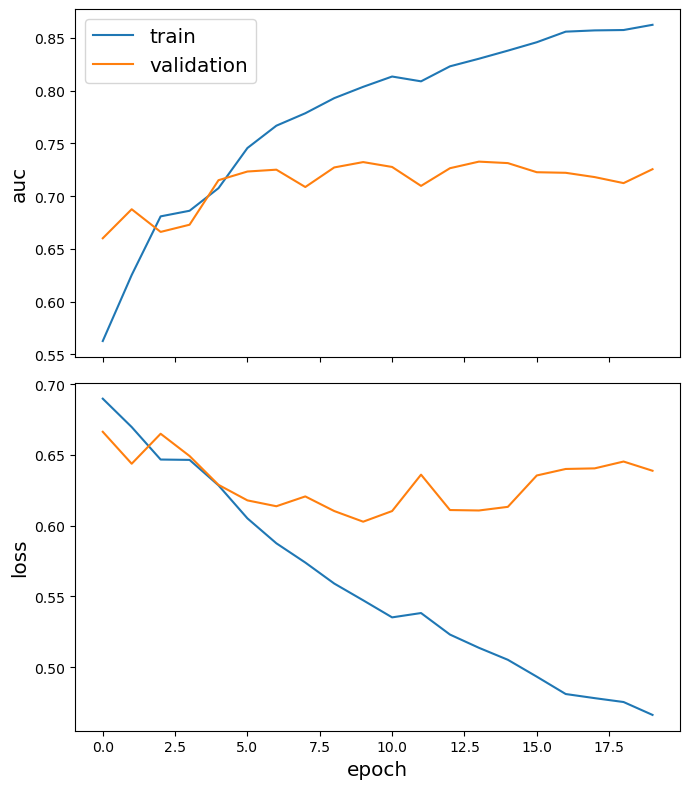

In [18]:
sg.utils.plot_history(history)

In [19]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

375/375 [==============================] - 2s 5ms/step - loss: 0.6377 - auc: 0.7267

Train Set Metrics of the trained model:
	loss: 0.4204
	auc: 0.9014

Test Set Metrics of the trained model:
	loss: 0.6377
	auc: 0.7267


In [20]:
edge_ids_test

array([['CC1=CC23C(=O)C(C=C(CO)C(O)C2(O)C1O)C1C(CC3C)C1(C)C',
        'Euphorbia fischeriana'],
       ['CC(=O)OC1C(OC2CCC34CC35CCC3(C)C(C6(C)CC(C(C)(C)O)CO6)C(O)CC3(C)C5CC(OC3OCC(O)C(O)C3O)C4C2(C)C)OCC(O)C1O',
        'Astragalus babatagi'],
       ['CCCCCCCCCCCCCCCCCCCCCCCCCC', 'Cistus laurifolius'],
       ...,
       ['CC(C)COC(=O)c1ccccc1C(=O)OCC(C)C', 'Dudleya brittonii'],
       ['CC(=O)C1=CC2(C)C(CCC(=O)C2C)C1', 'Aconitum falconeri'],
       ['CC(=O)OC1(C)C(=O)CC2C(C)(C)CCCC2(C)C12CCC1(COC(=O)C1)O2',
        'Maytenus chubutensis']], dtype=object)

In [21]:
out = model.predict(test_flow)

375/375 [==============================] - 2s 5ms/step


In [22]:
out

array([[0.7519769 ],
       [0.47827545],
       [0.8903985 ],
       ...,
       [0.11373927],
       [0.16289078],
       [0.7767777 ]], dtype=float32)

In [23]:
np.mean(out[1500:3000])

0.5888084

In [24]:
np.mean(out[:2000])

0.6007016

In [25]:
min(out)

array([0.00582544], dtype=float32)

In [26]:
max(out)

array([0.94100666], dtype=float32)

In [27]:
x_id =np.array([['C=C1C(O)CC(OC(C)=O)C2(C)C(OC(C)=O)C(OC(C)=O)C3(O)C(C)=C(OC(C)=O)CC(C(OC(C)=O)C12)C3(C)C',
          'Taxus canadensis'],
               ['C=C1C(O)CC(OC(C)=O)C2(C)C(OC(C)=O)C(OC(C)=O)C3(O)C(C)=C(OC(C)=O)CC(C(OC(C)=O)C12)C3(C)C',
               'Homo sapiens']])

In [28]:
pred_gen = HinSAGELinkGenerator(G_test, 1, num_samples, head_node_types=["molecule", "species"]).flow(x_id)

KeyError: 'Node ID C=C1C(O)CC(OC(C)=O)C2(C)C(OC(C)=O)C(OC(C)=O)C3(O)C(C)=C(OC(C)=O)CC(C(OC(C)=O)C12)C3(C)C supplied to generator not found in graph'

In [ ]:
model.predict(pred_gen)

In [32]:
test = df_agg.iloc[:2,:]

In [35]:
test

,organism_taxonomy_09species,structure_smiles_2D,reference_wikidata,organism_taxonomy_08genus,organism_taxonomy_06family,organism_taxonomy_05order,organism_taxonomy_04class,organism_taxonomy_03phylum,organism_taxonomy_02kingdom,organism_taxonomy_01domain,structure_taxonomy_npclassifier_01pathway,structure_taxonomy_npclassifier_02superclass,structure_taxonomy_npclassifier_03class,total_papers_molecule,total_papers_species
0,Utricularia vulgaris,OCC1=CC(O)C2C=COC(OC3OC(CO)C(O)C(O)C3O)C12,1,Utricularia,Lentibulariaceae,Lamiales,Magnoliopsida,Streptophyta,Archaeplastida,Eukaryota,Terpenoids,Monoterpenoids,Iridoids monoterpenoids,415,5
1,Conyza pyrrhopappa,CCC(C)C(=O)OC(CC(C)C1CC(c2ccoc2)OC1=O)C1(C)C(=...,2,Conyza,Asteraceae,Asterales,Magnoliopsida,Streptophyta,Archaeplastida,Eukaryota,Terpenoids,Diterpenoids,NaN,2,110


In [36]:
from grape.datasets import get_okapi_tfidf_weighted_textual_embedding

In [42]:
embedding = get_okapi_tfidf_weighted_textual_embedding(
    "./data/lotus_aggregated.csv",
    separator=",",
    header=True,
    # The k1 and b are BM25 parameters.
    # They may be tuned using a number of hyper-parameter optimization techniques.
    k1 = 1.5,
    b = 0.75,
    columns=["structure_smiles_2D"],
    # Just set here any BERT-based model from huggingface.
    pretrained_model_name_or_path="seyonec/ChemBERTa-zinc-base-v1"
)

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 were not used when initializing BertModel: ['roberta.encoder.layer.5.attention.self.key.bias', 'roberta.encoder.layer.2.attention.self.value.bias', 'roberta.encoder.layer.5.attention.self.value.weight', 'roberta.encoder.layer.5.attention.self.query.weight', 'roberta.encoder.layer.0.output.dense.weight', 'roberta.encoder.layer.1.intermediate.dense.bias', 'roberta.encoder.layer.3.intermediate.dense.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.self.query.bias', 'roberta.encoder.layer.0.attention.self.query.weight', 'roberta.encoder.layer.5.output.dense.weight', 'roberta.embeddings.word_embeddings.weight', 'lm_head.dense.weight', 'roberta.encoder.layer.4.output.dense.weight', 'roberta.encoder.layer.1.attention.output.dense.weight', 'roberta.encoder.layer.0.intermediate.dense.bias', 'roberta.encoder.layer.4.intermedia

In [45]:
embedding.shape

(20000, 768)

In [46]:
from grape import Graph
help(Graph.from_csv)

Help on built-in function from_csv:

from_csv(directed, node_type_path, node_type_list_separator, node_types_column_number, node_types_column, node_types_ids_column_number, node_types_ids_column, number_of_node_types, numeric_node_type_ids, minimum_node_type_id, node_type_list_header, node_type_list_support_balanced_quotes, node_type_list_rows_to_skip, node_type_list_is_correct, node_type_list_max_rows_number, node_type_list_comment_symbol, load_node_type_list_in_parallel, node_path, node_list_separator, node_list_header, node_list_support_balanced_quotes, node_list_rows_to_skip, node_list_is_correct, node_list_max_rows_number, node_list_comment_symbol, default_node_type, nodes_column_number, nodes_column, node_types_separator, node_list_node_types_column_number, node_list_node_types_column, node_ids_column, node_ids_column_number, number_of_nodes, minimum_node_id, numeric_node_ids, node_list_numeric_node_type_ids, skip_node_types_if_unavailable, load_node_list_in_parallel, edge_type_p